In [29]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.mesh import mesh_from_OrderedDict
from skfem import Basis, ElementTriP0
from femwell.mode_solver import compute_modes
from femwell.thermal import solve_thermal

from phodex.materials import n_si3n4, n_sio2, n_si

This is basically the [TiN TOPS heater example](https://helgegehring.github.io/femwell/photonics/examples/metal_heater_phase_shifter.html) from the femwell docs but does the calculation for a bent silicon nitride waveguide.

https://opg.optica.org/oe/fulltext.cfm?uri=oe-27-8-10456&id=408126

https://aip.scitation.org/doi/10.1063/1.4996314

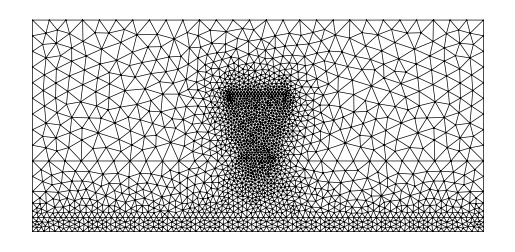

In [61]:
lcen = 1.55
radius = 50.06274
w_sim = 16
h_clad = 5
h_box = 2
w_core = 1.0
h_core = 0.3
h_heater = 0.14
w_heater = 2
offset_heater = 2 + (h_core + h_heater) / 2
h_silicon = 0.5

to_coeff_sio2 = 0.9e-5
to_coeff_sin = 2.45e-5
to_coeff_si = 1.48e-4

tc_sin = 90
tc_sio2 = 1.4
tc_tin = 28
tc_si = 148

polygons = dict(
    bottom=LineString(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    wafer=Polygon(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.1, "distance": 2},
    clad={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 2},
    wafer={"resolution": 0.2, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6)
)
mesh.draw().show()

In [92]:
currents = np.linspace(0, 1e-2, 10)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": tc_sin,
        "box": tc_sio2,
        "clad": tc_sio2,
        "heater": tc_tin,
        "wafer": tc_si,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

    basis, temperature = solve_thermal(
        basis0,
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom": 0},
    )

    temperature = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "core": n_si3n4(lcen)
        + to_coeff_sin * temperature[basis0.get_dofs(elements="core")],
        "clad": n_sio2(lcen)
        + to_coeff_sio2 * temperature[basis0.get_dofs(elements="clad")],
        "box": n_sio2(lcen)
        + to_coeff_sio2 * temperature[basis0.get_dofs(elements="box")],
        "wafer": n_si(lcen)
        + to_coeff_si * temperature[basis0.get_dofs(elements="wafer")],
        "heater": 3.1477,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2
    epsilon += basis0.project(
        lambda x: -10j * np.maximum(0, x[0] - 2) ** 2, dtype=complex
    )

    lams, _, _ = compute_modes(
        basis0,
        epsilon,
        wavelength=lcen,
        num_modes=1,
        order=2,
        radius=radius,
        n_guess=1.57684,
        solver="scipy",
    )

    neffs.append(np.real(lams[0]))

100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Phase shift: 0.5600049541692981


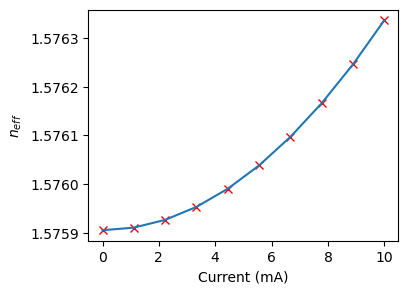

In [93]:
print(f"Phase shift: {2 * np.pi / lcen * (neffs[-1] - neffs[0]) * 320}")

p = np.polyfit(currents, neffs, 2)

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(currents * 1e3, neffs, "rx")
ax.plot(currents * 1e3, np.polyval(p, currents))
ax.set_xlabel("Current (mA)")
ax.set_ylabel("$n_{eff}$")
plt.show()